# RNN with Tensorflow for tweets sentiment analysis

## SBM - WEM Project

* Date : 30.04.21
* Authors : Capocasale Romain, Chassot Laurent and Moulin Vincent

## Imports

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import spacy
import preprocessor as tp
import tensorflow as tf

from SBM.TextProcessor import *

## Load data

In [2]:
df_train = pd.read_csv(os.path.join("data", "train_data.csv"), usecols = ['Text','Annotation', 'oh_label'])
df_test = pd.read_csv(os.path.join("data", "test_data.csv"), usecols = ['Text','Annotation', 'oh_label'])

In [3]:
tp = TextProcessor(remove_stop_word=True, 
remove_punctuation=True, 
      twitter_tokens=None, 
      min_word_size=2,
      special_token_method=SpecialTokenMethod.PREPROCESS)

In [4]:
train_preprocessed = tp.transform(df_train['Text'].to_numpy())

In [5]:
test_preprocessed = tp.transform(df_test['Text'].to_numpy())

In [6]:
df_train['Text'] = train_preprocessed
df_test['Text'] = test_preprocessed


#df_bull = df_train[df_train['oh_label'] == 1.0]
#df_no_bull = df_train[df_train['oh_label'] == 0.0]
#df_no_bull = df_no_bull.head(6000)
#frames = [df_bull, df_no_bull]

#df_train = pd.concat(frames, sort=False)

In [7]:
len_bullying_train = len(df_train[df_train['oh_label'] == 1.0])
len_no_bullying_train = len(df_train[df_train['oh_label'] == 0.0])

len_bullying_test = len(df_test[df_test['oh_label'] == 1.0])
len_no_bullying_test = len(df_test[df_test['oh_label'] == 0.0])

Text(0.5, 0.98, 'Tweet class repartition for train set')

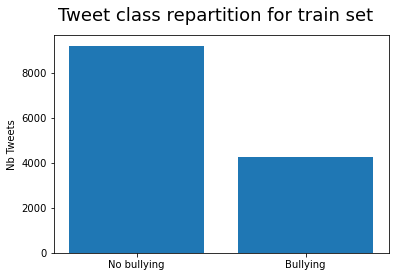

In [8]:
fig, ax = plt.subplots()
ax.bar(["No bullying", "Bullying"], [len_no_bullying_train, len_bullying_train])
ax.set_ylabel("Nb Tweets")
fig.suptitle("Tweet class repartition for train set", fontsize=18)

# Data augmentation

In [9]:
#import random

#df_bullying = df_train[df_train['oh_label'] == 1.0]
#size_train = len(df_bullying)

#for i in range (0, len_no_bullying_train-size_train):
#    rand = random.randint(0,size_train)
#    data = df_bullying.iloc[rand]
#    new_row = {'Text':data['Text'], 'Annotation':data['Annotation'], 'oh_label':data['oh_label']}
#    df_train = df_train.append(new_row, ignore_index=True)

#print(len(df_train))

In [10]:
#len_bullying_train = len(df_train[df_train['oh_label'] == 1.0])
#len_no_bullying_train = len(df_train[df_train['oh_label'] == 0.0])

#fig, ax = plt.subplots()
#ax.bar(["No bullying", "Bullying"], [len_no_bullying_train, len_bullying_train])
#ax.set_ylabel("Nb Tweets")
#fig.suptitle("Tweet class repartition for train set", fontsize=18)

Text(0.5, 0.98, 'Tweet class repartition for test set')

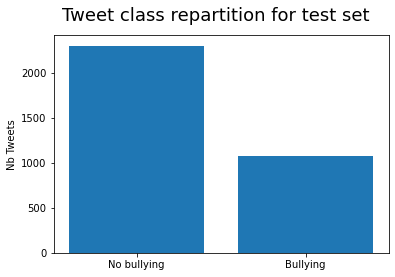

In [11]:
fig, ax = plt.subplots()
ax.bar(["No bullying", "Bullying"], [len_no_bullying_test, len_bullying_test])
ax.set_ylabel("Nb Tweets")
fig.suptitle("Tweet class repartition for test set", fontsize=18)

## Split dataset tweets/labels

In [12]:
X_train, y_train = df_train.iloc[:, :-2], df_train.iloc[:, 2]
X_test, y_test = df_test.iloc[:, :-2], df_test.iloc[:, 2]

In [13]:
weight_for_0 = (1 / len_no_bullying_train)*(len(df_train))/2.0 
weight_for_1 = (1 / len_bullying_train)*(len(df_train))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.73
Weight for class 1: 1.58


## Plot metrics

In [14]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Dataset preparation

In [204]:
BUFFER_SIZE = 100
BATCH_SIZE = 256

In [205]:
train_set = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
test_set = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

train_dataset = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [206]:
for feat, label in train_dataset.take(1):
  print('Features: {}, Target: {}'.format(feat, label))

Features: [[b'$MENTION$ $MENTION$ yes islam generate level barbarity hatred inhumanity $URL$']
 [b'$RESERVED$ $MENTION$ believe go $NUMBER$ rest comp $HASHTAG$ $HASHTAG$']
 [b'$MENTION$ guide understand difference loner cult microbrain $URL$']
 [b'vote number$/10 sure kat andre home know strategic voting $HASHTAG$']
 [b'$MENTION$ agree hadiths classify sound hadiths writer classify weak']
 [b'$RESERVED$ $MENTION$ $MENTION$ want person twitter $URL$']
 [b'$RESERVED$ $MENTION$ armenian church mosul torch islamic state $URL$']
 [b'$RESERVED$ $MENTION$ $HASHTAG$ $HASHTAG$ swear quote direction']
 [b'team steve $HASHTAG$']
 [b'honestly understand attack man $MENTION$ mention$.']
 [b'$MENTION$ $MENTION$ lol make excuse attack kurds isis hold steal include raqqa']
 [b'$MENTION$ wat ok rerun update vodka duck fat wear']
 [b'$MENTION$ hey $MENTION$ translate nonsensical nonanswer ty $MENTION$']
 [b'$MENTION$ $MENTION$ attempt stand ground open easy pick coalition air']
 [b'$MENTION$ love wear w

## Training

In [207]:
#VOCAB_SIZE = 50000
#max_tokens=VOCAB_SIZE

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))


In [208]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'mention', 'hashtag', 'reserved', 'url', 'number',
       'woman', 'sexist', 'kat', 'like', 'islam', 'think', 'people',
       'amp', 'girl', 'know', 'go', 'man', 'andre'], dtype='<U120')

In [209]:
tf.keras.backend.clear_session()

modelLSTM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

modelGRU = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.GRU(16, activation='tanh', return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GRU(8, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelRNN = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


model = modelGRU

In [210]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [211]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [212]:
history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset, class_weight=class_weight, callbacks=[early_stopping])

Epoch 1/15
53/53 [==============================] - 6s 45ms/step - loss: 0.6919 - accuracy: 0.5653 - val_loss: 0.6891 - val_accuracy: 0.5961
Epoch 2/15
53/53 [==============================] - 2s 41ms/step - loss: 0.6857 - accuracy: 0.6100 - val_loss: 0.6843 - val_accuracy: 0.6157
Epoch 3/15
53/53 [==============================] - 2s 38ms/step - loss: 0.6753 - accuracy: 0.6511 - val_loss: 0.6736 - val_accuracy: 0.6555
Epoch 4/15
53/53 [==============================] - 2s 41ms/step - loss: 0.6561 - accuracy: 0.6999 - val_loss: 0.6522 - val_accuracy: 0.6947
Epoch 5/15
53/53 [==============================] - 2s 41ms/step - loss: 0.6209 - accuracy: 0.7539 - val_loss: 0.6135 - val_accuracy: 0.7389
Epoch 6/15
53/53 [==============================] - 2s 39ms/step - loss: 0.5696 - accuracy: 0.7941 - val_loss: 0.5648 - val_accuracy: 0.7650
Epoch 7/15
53/53 [==============================] - 2s 40ms/step - loss: 0.5068 - accuracy: 0.8202 - val_loss: 0.5178 - val_accuracy: 0.7852
Epoch 8/15
53

In [213]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


14/14 [==============================] - 0s 8ms/step - loss: 0.4659 - accuracy: 0.8012
Test Loss: 0.4659106731414795
Test Accuracy: 0.8011869192123413


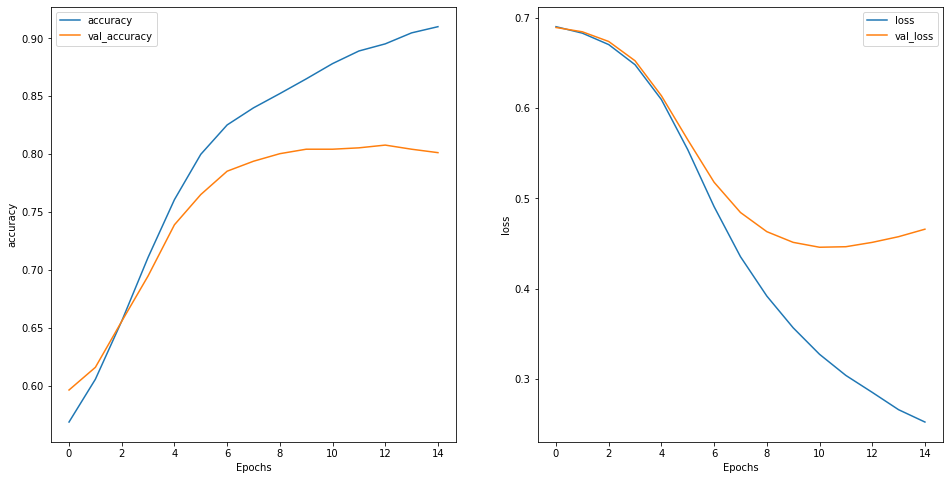

In [214]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [215]:
predictions2 = np.where(model.predict(X_test) > 0.5, 1, 0)

In [216]:
from sklearn.metrics import classification_report, confusion_matrix

In [217]:
print(confusion_matrix(y_test,predictions2))

[[1939  361]
 [ 309  761]]


In [218]:
print(classification_report(y_test, predictions2))

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      2300
         1.0       0.68      0.71      0.69      1070

    accuracy                           0.80      3370
   macro avg       0.77      0.78      0.77      3370
weighted avg       0.80      0.80      0.80      3370

